# ANÁLISE DE ACESSIBILIDADE EM TERESINA - ATRIBUIÇÃO DE VELOCIDADES

Autor: Felipe Ramos Dantas
Data: 23/01/2026

---

OBS: Se o conjunto de dados já estiver pré-processados, isto é, se já tiver sido feita a filtragem pelo tipo da via e por sua classificação, vá direto para o item "4. Cálculo de Impedância Multimodal"

---

## 1. Importação das bibliotecas

In [7]:
import os
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, Polygon, MultiPoint
import numpy as np
import city2graph as c2g
import city2graph.data as c2g_data
import city2graph.morphology as c2g_morpho
import city2graph.utils as c2g_utils

import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

# Configurações visuais e de sistema
pd.set_option('display.max_columns', None)

print("Bibliotecas carregadas com sucesso!")

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.style.use('ggplot')

print("Parametros globais de gráfico!")

Bibliotecas carregadas com sucesso!
Parametros globais de gráfico!


## 2. Carregando os Dados

In [8]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================

# DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI
caminho_segments = "../dados/processados/overturemaps/the_bbox_om_segments_gnn.gpkg"
layer = 'the_bbox_om_segments_gnn'
caminho_connectors = "../dados/brutos/overturemaps/the_bbox_connector.geojson"

# 1. Carregar os GeoJSONs
print("Carregando arquivos...\n")
gdf_segments = gpd.read_file(caminho_segments)
gdf_connectors = gpd.read_file(caminho_connectors)

Carregando arquivos...



In [9]:
gdf_segments.tail(3)

,id,subtype,class,names,length,length_norm,linearity,class_original,surface_clean,y_encoded,class_ml_gnn,geometry
66483,7a038a15-0d30-4554-b09a-dd6404226c6d,road,tertiary,None,1098.665881,1098.665881,0.974841,tertiary,unpaved,8,tertiary,"LINESTRING (765028.882 9459501.806, 764997.044..."
66484,98d015f1-a71a-4e8c-b7c6-11198b79694e,road,track,None,381.402605,381.402605,0.962196,track,unknown,9,track,"LINESTRING (765191.458 9459100.596, 765257.679..."
66485,950f19f2-7635-4258-bec8-a7270f1b0a19,road,tertiary,None,4887.546921,4887.546921,0.961672,tertiary,unpaved,8,tertiary,"LINESTRING (769471.043 9457965.826, 769462.123..."


## 3. Análise e Pré-processamento

### 3.1 Definir o Sistema de Referência (CRS) para Teresina (SIRGAS 2000 / UTM 23S)

Reprojetando para UTM Zona 23S (Metros)...

Total de Trechos (Arestas): 66486
Total de Conectores (Nós): 49664


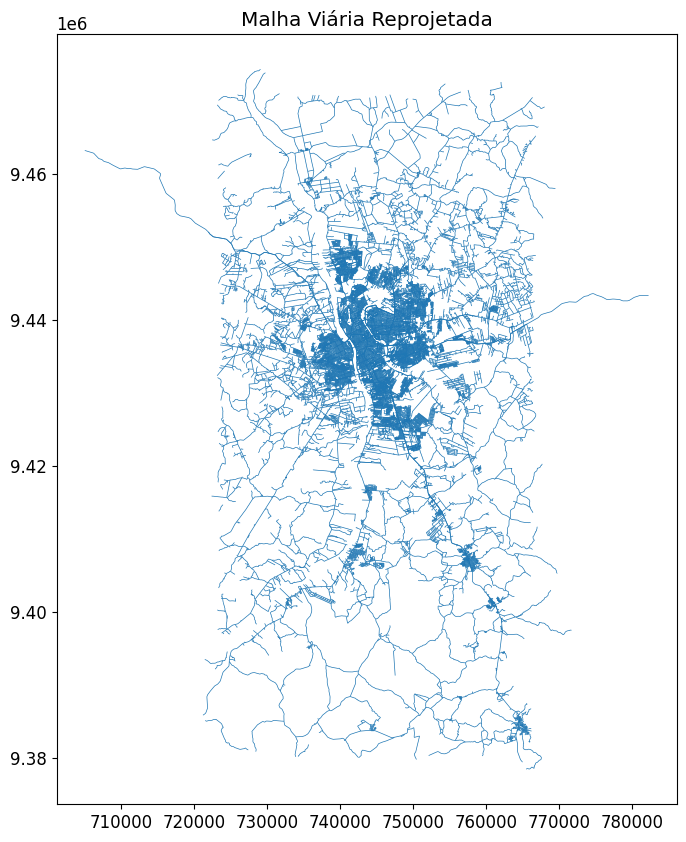

In [ ]:
# EPSG:31983 é o código oficial para sua zona.
CRS_METRICO = "EPSG:31983"

print("Reprojetando para UTM Zona 23S (Metros)...\n")
gdf_segments = gdf_segments.to_crs(CRS_METRICO)
gdf_connectors = gdf_connectors.to_crs(CRS_METRICO)

# Visualização rápida para confirmar
print(f"Total de Trechos (Arestas): {len(gdf_segments)}")
print(f"Total de Conectores (Nós): {len(gdf_connectors)}")
gdf_segments.plot(linewidth=0.5, figsize=(10, 10))
plt.title("Malha Viária Reprojetada")
plt.show()

### 3.2 Pré-filtro: Remover o que não é estrada (road)

In [ ]:
# Overture mistura 'road' e 'rail' no subtype. Vamos ficar só com 'road'.
# Se houver valores nulos em subtype, também removeremos.
# Também excluiremos as vias classificadas com 'service'.
# Verificamos o que tem antes
print("Subtypes antes do filtro:", gdf_segments['subtype'].unique())
print(f"Total original: {len(gdf_segments)}\n")

gdf_road = gdf_segments[
    (gdf_segments['subtype'] == 'road') & (gdf_segments['class'] != 'service')
].copy()

print("Subtypes após filtro:", gdf_road['subtype'].unique())

print(f"Total após filtro (apenas 'road'): {len(gdf_road)}")

Subtypes antes do filtro: ['road' 'rail' 'water']
Total original: 66486

Subtypes após filtro: ['road']
Total após filtro (apenas 'road'): 63548


### 3.3 Listar classes de vias para definição de velocidade

In [18]:
# Isso responde à sua pergunta sobre quais valores existem na coluna 'class'
print("\n--- VALORES ÚNICOS NA COLUNA 'CLASS' ---")
valores_class = gdf_road['class_ml_gnn'].unique().tolist()
print(valores_class)

print("\n--- PREVIEW DOS DADOS (Colunas úteis) ---")
print(gdf_road[['id', 'subtype', 'class_ml_gnn', 'length']].head())


--- VALORES ÚNICOS NA COLUNA 'CLASS' ---
['residential', 'track', 'tertiary', 'primary', 'secondary', 'trunk', 'footway', 'living_street', 'pedestrian']

--- PREVIEW DOS DADOS (Colunas úteis) ---
                                     id subtype class_ml_gnn       length
0  6d775c41-5cf2-493e-b402-cfcbd8972262    road  residential   720.449364
1  aec4047f-e9b3-4c2b-ba48-c1c065ffc97e    road  residential  2081.823556
2  fabe85df-cfbc-4adc-a6e7-7a41c44f39c6    road  residential  1099.216268
3  7b0e2bea-3908-4ba4-93da-6f9ff6f06056    road  residential   540.386635
4  87309c7e-7195-4237-9d45-42570008a3b4    road        track   665.671536


In [19]:
gdf_road.to_file(
        "../outputs/vectors/the_bbox_overturemaos_gnn_vel_modal_filter.gpkg", 
        driver="GPKG", 
        layer="the_bbox_overturemaos_gnn_vel_modal_filter"
)

## 4. Cálculo de Impedância Multimodal (Corrigida)

### 4.1 Carregando os Dados

Só carregue os dados caso já o conjunto de dados já tenha sido filtrado por tipo e classe.

Carregando arquivos...

Arquivos carregados!
Total de Trechos (Arestas): 63548


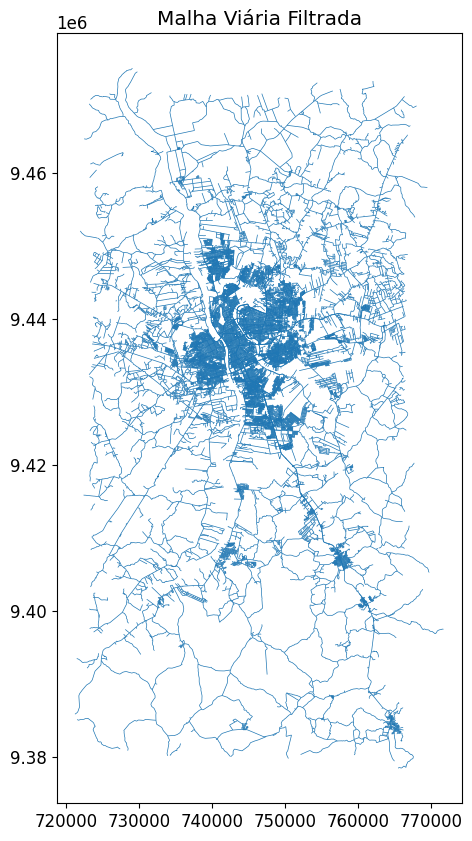

In [2]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================

# DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI
caminho_segments = "../outputs/vectors/the_bbox_overturemaos_gnn_vel_modal_filter.gpkg"
layer = 'the_bbox_overturemaos_gnn_vel_modal_filter'

# 1. Carregar os Geopackages
print("Carregando arquivos...\n")
gdf_road = gpd.read_file(caminho_segments)
print("Arquivos carregados!")

# Visualização rápida para confirmar
print(f"Total de Trechos (Arestas): {len(gdf_road)}")
gdf_road.plot(linewidth=0.5, figsize=(10, 10))
plt.title("Malha Viária Filtrada")
plt.show()

In [3]:
gdf_road.head(2)

,id,subtype,class,names,length,length_norm,linearity,class_original,surface_clean,y_encoded,class_ml_gnn,geometry
0,6d775c41-5cf2-493e-b402-cfcbd8972262,road,residential,None,720.449364,720.449364,0.973612,unclassified,unpaved,-1,residential,"LINESTRING (723376.977 9408354.072, 723403.887..."
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,road,residential,None,2081.823556,2081.823556,0.999003,unclassified,unpaved,-1,residential,"LINESTRING (724465.971 9415641.369, 724036.799..."


### 4.2 Cálculo de Impedância

#### 4.2.1 Matriz de Velocidades (km/h)

In [7]:
print("Configurando parâmetros de velocidade para cálculo de impedância...")

# Definição baseada na hierarquia viária e condições físicas esperadas.

velocidades_kmh = {
    # CLASSE           CARRO   MOTO    A PÉ
    'trunk':          {'car': 80, 'moto': 80, 'walk': 0},   # Vias expressas
    'primary':        {'car': 60, 'moto': 60, 'walk': 5},   # Via arterial
    'secondary':      {'car': 40, 'moto': 40, 'walk': 5},   # Via Coletora
    'tertiary':       {'car': 40, 'moto': 40, 'walk': 5},   # Via Coletora
    'residential':    {'car': 30, 'moto': 30, 'walk': 5},   # Via local
    'living_street':  {'car': 20, 'moto': 20, 'walk': 5},   # via local compartilhda com pesdestre de baixa velocidade
    #'service':        {'car': 20, 'moto': 20, 'walk': 5},   # Excluído na filtragem
    'track':          {'car': 60, 'moto': 60, 'walk': 5},   # Terra
    'footway':        {'car': 0,  'moto': 0,  'walk': 5},   # calçadas
    'pedestrian':     {'car': 0,  'moto': 0,  'walk': 5},   # calçadas
}

Configurando parâmetros de velocidade para cálculo de impedância...


#### 4.2.2 Função de Cálculo Vetorizada (Aplicada linha a linha)

In [8]:
def calcular_tempos_multimodais(row):
    """
    Calcula o tempo de viagem (em minutos) para Carro, Moto e A Pé.
    Fórmula: Tempo = Distância / Velocidade
    """
    # 1. Identificação da Classe
    # Tenta pegar 'class' (padrão), se não achar, tenta 'class_ml_gnn'
    classe = row.get('class', row.get('class_ml_gnn'))
    
    # Validação de segurança: Se a classe não estiver no dicionário, lança erro ou usa padrão seguro
    # Como garantimos que não há 'unknown', usamos 'residential' como fallback de segurança extrema
    if classe not in velocidades_kmh:
        # print(f"Aviso: Classe '{classe}' não mapeada. Usando perfil 'residential'.")
        perfil = velocidades_kmh['residential']
    else:
        perfil = velocidades_kmh[classe]

    # 2. Identificação da Distância
    # Prioriza 'length' (padrão Overture/Momepy), aceita 'length_norm' (GNN)
    distancia_m = row.get('length', row.get('length_norm', 0))
    
    tempos = {}
    
    # 3. Cálculo para cada modal
    for modo in ['car', 'moto', 'walk']:
        vel_kmh = perfil[modo]
        
        # Condição de Bloqueio: Velocidade 0 ou Distância inválida
        if vel_kmh <= 0 or distancia_m <= 0:
            tempos[f'time_{modo}_min'] = np.inf # Infinito = Bloqueio total no Grafo
        else:
            # Conversão de Unidades:
            # Velocidade (m/min) = (km/h * 1000) / 60
            vel_mpm = (vel_kmh * 1000) / 60
            
            # Tempo (min) = Metros / (Metros/Minuto)
            tempos[f'time_{modo}_min'] = distancia_m / vel_mpm
            
    return pd.Series(tempos)

#### 4.2.3 Limpeza Preventiva

In [9]:
# Remove colunas antigas para evitar duplicação caso a célula seja reexecutada
cols_tempo = ['time_car_min', 'time_moto_min', 'time_walk_min']
cols_existentes = [c for c in cols_tempo if c in gdf_road.columns]
if cols_existentes:
    print(f"Limpando cálculos anteriores: {cols_existentes}")
    gdf_road = gdf_road.drop(columns=cols_existentes)

#### 4.4.4 Execução do Cálculo

In [12]:
print("Calculando novas impedâncias (Custos de Travessia)...")
novas_colunas = gdf_road.apply(calcular_tempos_multimodais, axis=1)

# Concatenação segura
gdf_road = pd.concat([gdf_road, novas_colunas], axis=1)

Calculando novas impedâncias (Custos de Travessia)...


#### 4.4.5 Validação dos Resultados

In [13]:
print("\n--- AMOSTRA ATUALIZADA ---")
# Monta lista de colunas para visualizar, verificando se existem
cols_view = ['class', 'time_car_min', 'time_walk_min']
if 'length' in gdf_road.columns: cols_view.insert(1, 'length')
elif 'length_norm' in gdf_road.columns: cols_view.insert(1, 'length_norm')

print(gdf_road[cols_view].head(10))


--- AMOSTRA ATUALIZADA ---
         class       length  time_car_min  time_walk_min
0  residential   720.449364      1.440899       8.645392
1  residential  2081.823556      4.163647      24.981883
2  residential  1099.216268      2.198433      13.190595
3  residential   540.386635      1.080773       6.484640
4        track   665.671536      0.665672       7.988058
5  residential   973.132207      1.946264      11.677586
6  residential    57.470799      0.114942       0.689650
7  residential  3354.665865      6.709332      40.255990
8  residential  1468.727184      2.937454      17.624726
9  residential    97.219294      0.194439       1.166632


In [14]:
# Verificação de Integridade
bloqueios_carro = len(gdf_road[gdf_road['time_car_min'] == np.inf])
print(f"\nResumo de Bloqueios:")
print(f"- Segmentos intransitáveis para Carros: {bloqueios_carro}")
print(f"- Segmentos intransitáveis para Pedestres: {len(gdf_road[gdf_road['time_walk_min'] == np.inf])}")


Resumo de Bloqueios:
- Segmentos intransitáveis para Carros: 525
- Segmentos intransitáveis para Pedestres: 845


In [15]:
gdf_road.head(3)

,id,subtype,class,names,length,length_norm,linearity,class_original,surface_clean,y_encoded,class_ml_gnn,geometry,time_car_min,time_moto_min,time_walk_min
0,6d775c41-5cf2-493e-b402-cfcbd8972262,road,residential,None,720.449364,720.449364,0.973612,unclassified,unpaved,-1,residential,"LINESTRING (723376.977 9408354.072, 723403.887...",1.440899,1.440899,8.645392
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,road,residential,None,2081.823556,2081.823556,0.999003,unclassified,unpaved,-1,residential,"LINESTRING (724465.971 9415641.369, 724036.799...",4.163647,4.163647,24.981883
2,fabe85df-cfbc-4adc-a6e7-7a41c44f39c6,road,residential,None,1099.216268,1099.216268,0.968581,unclassified,unpaved,-1,residential,"LINESTRING (723945.476 9414665.026, 723870.213...",2.198433,2.198433,13.190595


In [ ]:
# Salvamento temporário para inspeção no QGIS
gdf_road.to_file(
    "../outputs/vectors/the_bbox_overturemaos_gnn_filter_impedancia.gpkg", 
    layer='the_bbox_overturemaos_gnn_filter_impedancia', 
    driver='GPKG'
)

In [ ]:
print("Convertendo malha viária para Grafo NetworkX...")

# 1. Conversão usando momepy
# approach='primal': Nós são intersecções, Arestas são ruas
# O momepy preserva TODAS as colunas do gdf (time_car_min, time_moto_min, etc) como atributos
#G = momepy.gdf_to_nx(gdf_road, approach='primal', length='length')
G = c2g_morpho.segments_to_graph(
    segments_gdf = gdf_road,
    multigraph = False,
    as_nx = True,
)

print("Grafo criado com sucesso!")
print(f"Número de Nós: {G.number_of_nodes()}")
print(f"Número de Arestas: {G.number_of_edges()}")

# 2. Verificação de Atributos
# Vamos confirmar se as colunas de tempo entraram no grafo
exemplo_aresta = list(G.edges(data=True))[0] # Pega a primeira rua
print("\n--- ATRIBUTOS DA PRIMEIRA ARESTA ---")
print(f"Tempo Carro: {exemplo_aresta[2].get('time_car_min')} min")
print(f"Tempo Moto:  {exemplo_aresta[2].get('time_moto_min')} min")
print(f"Tempo Pé:    {exemplo_aresta[2].get('time_walk_min')} min")

Convertendo malha viária para Grafo NetworkX...
Grafo criado com sucesso!
Número de Nós: 43501
Número de Arestas: 63314

--- ATRIBUTOS DA PRIMEIRA ARESTA ---
Tempo Carro: 1.440898727442228 min
Tempo Moto:  1.440898727442228 min
Tempo Pé:    8.645392364653368 min


In [37]:
# 2. Diagnóstico de Topologia
# O City2Graph pode criar componentes desconexos. Vamos garantir que usamos o principal.
# (Mesma segurança de antes, mas agora aplicada sobre o grafo já limpo pelo C2G)
componentes = list(nx.connected_components(G))
if len(componentes) > 1:
    print(f"Aviso: O grafo possui {len(componentes)} ilhas desconectadas.")
    print("Mantendo apenas o Maior Componente (Rede Principal)...")
    maior_componente = max(componentes, key=len)
    G = G.subgraph(maior_componente).copy()
    print(f"Nós restantes no Grafo Principal: {len(G.nodes)}")
else:
    print("Sucesso: O grafo é totalmente conectado (sem ilhas)!")

Aviso: O grafo possui 1244 ilhas desconectadas.
Mantendo apenas o Maior Componente (Rede Principal)...
Nós restantes no Grafo Principal: 40792


In [38]:
# 3. Verificação de Atributos (Crucial)
# Precisamos confirmar se 'time_car_min' sobreviveu à conversão
try:
    exemplo = list(G.edges(data=True))[0]
    print("\n--- AUDITORIA DE ATRIBUTOS (Primeira Aresta) ---")
    print(f"Classe: {exemplo[2].get('class', 'N/A')}")
    print(f"Tempo Carro: {exemplo[2].get('time_car_min'):.4f} min")
    print(f"Tempo Pé:    {exemplo[2].get('time_walk_min'):.4f} min")
except Exception as e:
    print(f"ERRO CRÍTICO: Atributos perdidos na conversão. Detalhe: {e}")


--- AUDITORIA DE ATRIBUTOS (Primeira Aresta) ---
Classe: residential
Tempo Carro: 1.4409 min
Tempo Pé:    8.6454 min


## 5. Cálculo das Isócronas

### 5.1 Carregando dados de vias (com impedancia) e UBS

In [5]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================

print("Carregando segments de vias com impedancias")

# DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI
caminho_segments = "../outputs/vectors/the_bbox_overturemaos_gnn_filter_impedancia.gpkg"
layer = 'the_bbox_overturemaos_gnn_filter_impedancia'
caminho_connectors = "../dados/brutos/overturemaps/the_bbox_connector.geojson"

# 1. Carregar os GPKG
gdf_road = gpd.read_file(caminho_segments, layer=layer)
gdf_connectors = gpd.read_file(caminho_connectors)


# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================
print("Carregando pontos das UBS...")

# 1. Carregue seu arquivo de UBS (Ajuste o caminho se necessário)
# Se você tiver um arquivo .geojson, .shp ou .gpkg
#caminho_ubs = '../dados/terceiros/semplam/ubs_zu.geojson' # <--- CONFIRME ESSE CAMINHO/
caminho_ubs = '../dados/terceiros/semplam/ubs_zu_amostras_20perc.geojson' # <--- CONFIRME ESSE CAMINHO/


try:
    gdf_ubs = gpd.read_file(caminho_ubs)
except:
    # Caso não ache, tenta procurar na pasta vectors se você salvou lá antes
    gdf_ubs = gpd.read_file('../dados/terceiros/semplam/ubs_zu.geojson')

# 2. Padronização de CRS (Obrigatório ser igual ao Grafo: EPSG:31983)
if gdf_ubs.crs.to_string() != "EPSG:31983":
    print(f"Convertendo UBS de {gdf_ubs.crs} para EPSG:31983...\n")
    gdf_ubs = gdf_ubs.to_crs("EPSG:31983")

if gdf_road.crs.to_string() != "EPSG:31983":
    print(f"Convertendo ROAD de {gdf_road.crs} para EPSG:31983...")
    gdf_road = gdf_road.to_crs("EPSG:31983")

print(f"Total de UBS carregadas: {len(gdf_ubs)}")
print(f"CRS Ativo: {gdf_ubs.crs}")
print(f"\nTotal de ROAD carregadas: {len(gdf_road)}")
print(f"CRS Ativo: {gdf_road.crs}")

Carregando segments de vias com impedancias
Carregando pontos das UBS...
Convertendo UBS de EPSG:4674 para EPSG:31983...

Total de UBS carregadas: 18
CRS Ativo: EPSG:31983

Total de ROAD carregadas: 63548
CRS Ativo: EPSG:31983


In [6]:
# Visualiza as primeiras linhas para garantir que leu certo
gdf_ubs.head()

,fid,nome,cnes,logradouro,numero,bairro,cep,regional,geometry
0,1,UBS A BENICIO FREIRE E SILVA-POTY VELHO,2588811,RUA MARIO AUGUSTO FREITAS,1469,POTY VELHO,64005830,NORTE,POINT (740835.065 9442861.74)
1,5,UBS DR FELIPE EULALIO DE PADUA-PROMORAR,6901468,PRACA DO CENTRO DE PRODUCAO DO PROMORAR,QD 61,PROMORAR,64027140,SUL,POINT (745907.107 9430564.831)
2,7,UBS FERNANDO G C LIMA- PORTAL DA ALEGRIA,5343054,RUA 13/18,S/N,PORTAL DA ALEGRIA III,64037074,SUL,POINT (750039.886 9426002.207)
3,10,UBS DR HELVIDIO FERRAZ-TODOS OS SANTOS,2443937,AV. PROFESSOR CAMILO FILHO,6133,TODOS OS SANTOS,64089040,SUDESTE,POINT (752567.153 9435977.023)
4,20,UBS FRANCILIO RIBEIRO DE ALMEIDA-ANGELIM,2444135,RUA B,S/N,ANGELIM,64034360,SUL,POINT (744944.656 9427511.135)


### 5.2 Função das Isocrona

##### Célula: Geração de Isócronas com Alpha Shape (Nativo)

In [8]:
# Filtra avisos chatos de geometria do Pandas
warnings.filterwarnings('ignore')

def gerar_isocronas_alpha(grafo_edges, grafo_nodes, gdf_pontos, modo='car', limiares=[10, 20, 30]):
    """
    Gera isócronas usando o algoritmo nativo Alpha Shape do City2Graph.
    
    Parâmetros:
        grafo (nx.Graph): Grafo viário preparado.
        gdf_pontos (GeoDataFrame): Pontos de origem (UBS).
        modo (str): 'car' ou 'walk' (seleciona a impedância).
        limiares (list): Lista de tempos em minutos (ex: [10, 20, 30]).
    """
    attr_peso = f'time_{modo}_min'
    print(f"🚀 Iniciando cálculo Alpha Shape para {len(gdf_pontos)} UBS (Modo: {modo})...")
    
    resultados_finais = []
    
    # Barra de progresso para acompanhar o processamento
    for idx, row in tqdm(gdf_pontos.iterrows(), total=len(gdf_pontos)):
        try:
            # Dados da UBS atual
            ponto_ubs = row.geometry
            nome_ubs = row.get('nome', row.get('nome', f"UBS_{idx}"))
            cnes = row.get('cnes', 0)
            
            poligonos_cumulativos = []
            
            # --- 1. GERAÇÃO DOS POLÍGONOS (CUMULATIVOS) ---
            for tempo in limiares:
                # Chama a função nativa do City2Graph
                # Ela retorna um GeoDataFrame contendo a isócrona
                gdf_iso = c2g_utils.create_isochrone(
                    graph=grafo_edges,
                    nodes=grafo_nodes,
                    center_point=ponto_ubs,
                    threshold=tempo,           # Limite de tempo (ex: 10 min)
                    edge_attr=attr_peso,       # Coluna de peso (ex: 'time_car_min')
                    method='concave_hull_alpha', # <--- O SEGREDO (Alpha Shape)
                    hull_ratio=0.2,            # Ajuste de "concavidade" (0.0 a 1.0)
                    allow_holes=False          # Evita buracos dentro da mancha
                )
                
                # Se a função retornou geometria válida, guarda.
                if not gdf_iso.empty and not gdf_iso.geometry.iloc[0].is_empty:
                    poligonos_cumulativos.append(gdf_iso.geometry.iloc[0])
                else:
                    # Fallback: Se não achou nada (isolada), cria um ponto bufferizado
                    poligonos_cumulativos.append(ponto_ubs.buffer(50))

            # --- 2. CÁLCULO DAS DIFERENÇAS (ANÉIS/DONUTS) ---
            # Garante geometria válida com buffer(0)
            poly_10 = poligonos_cumulativos[0].buffer(0)
            poly_20 = poligonos_cumulativos[1].buffer(0)
            poly_30 = poligonos_cumulativos[2].buffer(0)
            
            # Subtrai as áreas para não haver sobreposição
            zona_1 = poly_10                                 # 0 a 10
            zona_2 = poly_20.difference(poly_10)             # 10 a 20
            zona_3 = poly_30.difference(poly_20)             # 20 a 30
            
            # --- 3. ESTRUTURAÇÃO DO DADO ---
            gdf_temp = gpd.GeoDataFrame({
                'id_ubs': [nome_ubs]*3,
                'cnes': [cnes]*3,
                'faixa': ['0-10', '10-20', '20-30'],
                'tempo_limite': limiares,
                'modo': [modo]*3
            }, geometry=[zona_1, zona_2, zona_3], crs=gdf_pontos.crs)
            
            resultados_finais.append(gdf_temp)
            
        except Exception as e:
            print(f"Erro na UBS {idx}: {e}") # Descomente para debug detalhado
            continue
            
    # Consolida tudo num único arquivo
    if resultados_finais:
        return pd.concat(resultados_finais, ignore_index=True)
    else:
        return gpd.GeoDataFrame()

print("🏁 Função 'gerar_isocronas_alpha' compilada e pronta.")

🏁 Função 'gerar_isocronas_alpha' compilada e pronta.


### 5.3 Execução da função Isocrona e Exportação dos Resultados

In [9]:
# Célula: Execução dos Cenários e Exportação

# Cria pasta de saída
os.makedirs("../outputs/vectors/testes/", exist_ok=True)

# --- CENÁRIO 1: CARRO ---
gdf_carro = gerar_isocronas_alpha(G, gdf_ubs, modo='car')

if not gdf_carro.empty:
    path_car = "../outputs/vectors/testes/iso_alpha_carro_02.gpkg"
    gdf_carro.to_file(path_car, driver="GPKG", )
    print(f"💾 Isócronas de CARRO salvas em: {path_car}")



NameError: name 'G' is not defined

In [ ]:
# --- CENÁRIO 2: A PÉ ---
gdf_walk = gerar_isocronas_alpha(G, gdf_ubs, modo='walk')

if not gdf_walk.empty:
    path_walk = "../outputs/vectors/testes/iso_alpha_walk_20.gpkg"
    gdf_walk.to_file(path_walk, driver="GPKG")
    print(f"💾 Isócronas A PÉ salvas em: {path_walk}")

🚀 Iniciando cálculo Alpha Shape para 18 UBS (Modo: walk)...


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


DataSourceError: sqlite3_open(outputs/vectors/testes/iso_alpha_walk_20.gpkg) failed: unable to open database file

### 5.4 Visualização do Resultado

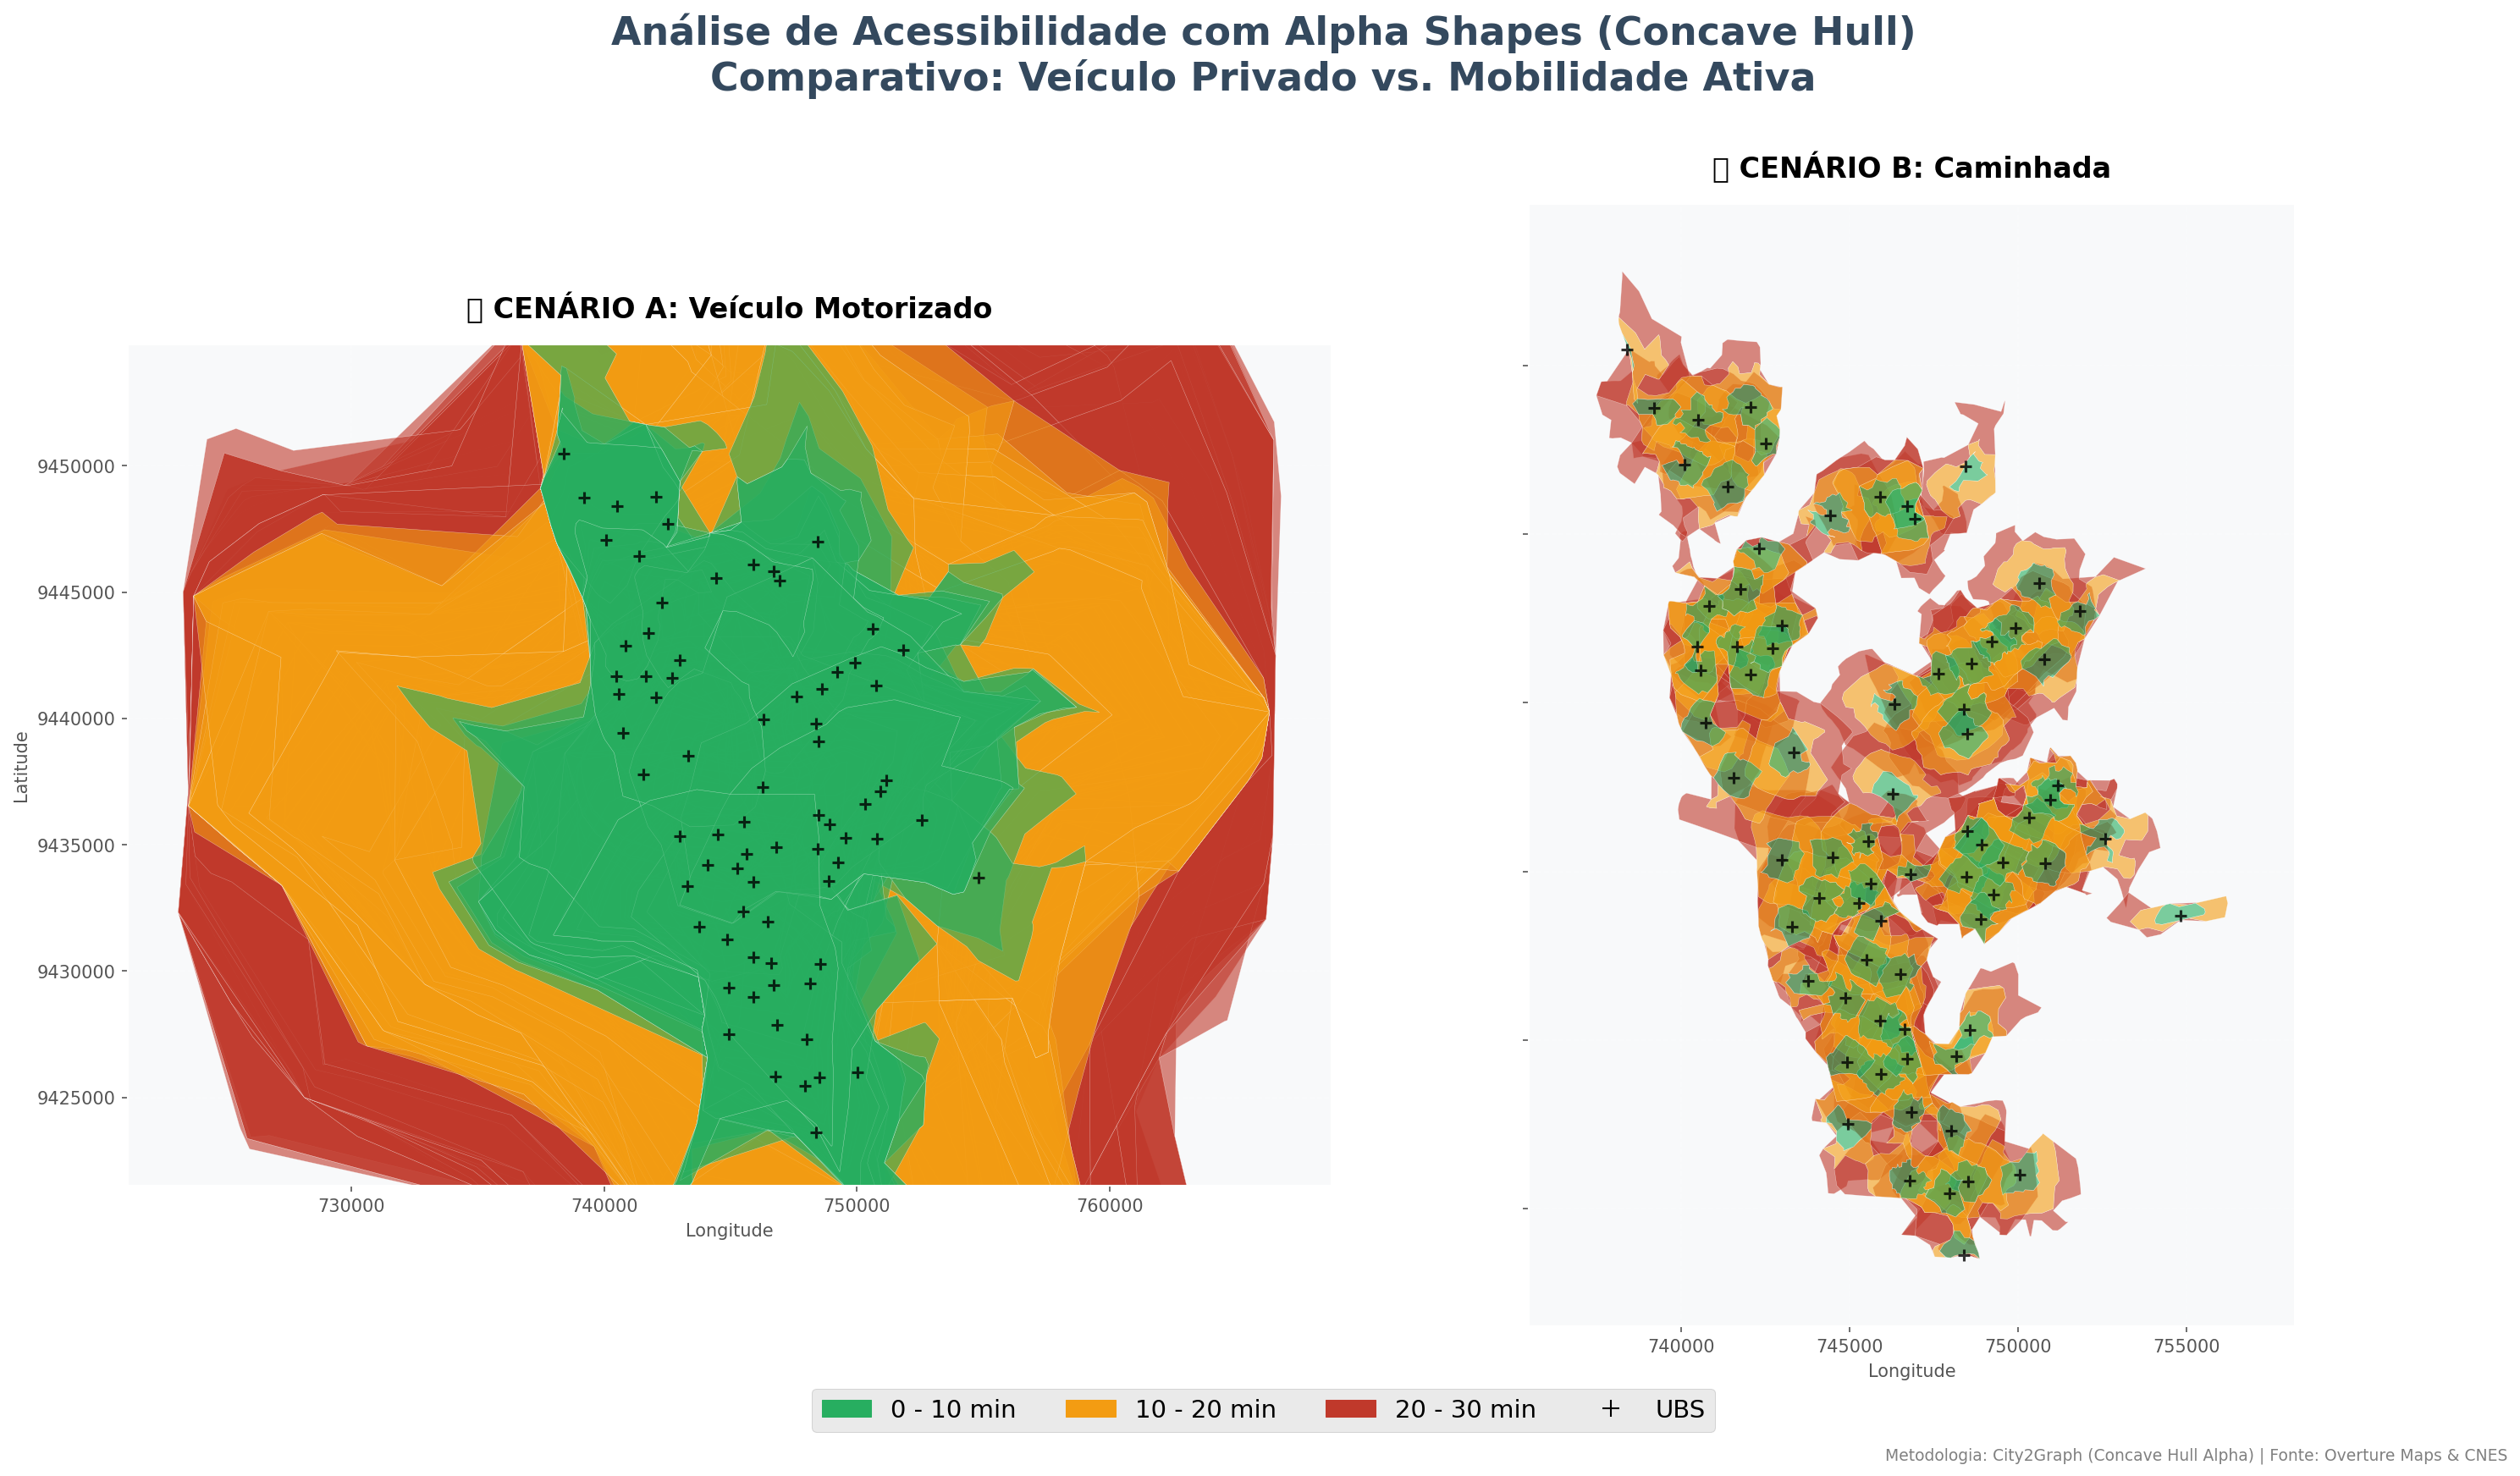

In [44]:
# Célula: Visualização Cartográfica Profissional (Comparativo)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plotar_comparacao_alpha(gdf_c, gdf_w, pontos_ubs):
    # Cores semânticas (Verde=Perto, Amarelo=Médio, Vermelho=Longe)
    cores = {'0-10': '#27ae60', '10-20': '#f39c12', '20-30': '#c0392b'}
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharey=True)
    
    # Título Principal
    fig.suptitle('Análise de Acessibilidade com Alpha Shapes (Concave Hull)\nComparativo: Veículo Privado vs. Mobilidade Ativa', 
                 fontsize=22, weight='bold', color='#34495e', y=0.96)

    # Configuração dos Cenários
    cenarios = [
        (gdf_c, axes[0], "CENÁRIO A: Veículo Motorizado", "🚗"),
        (gdf_w, axes[1], "CENÁRIO B: Caminhada", "🚶")
    ]

    for gdf, ax, titulo, icone in cenarios:
        if gdf.empty: continue
        
        # 1. Plotagem das Isócronas (Do maior para o menor para garantir visibilidade)
        # Como usamos Alpha Shape, as formas serão orgânicas e recortadas
        for faixa in ['20-30', '10-20', '0-10']:
            subset = gdf[gdf['faixa'] == faixa]
            if not subset.empty:
                subset.plot(ax=ax, color=cores[faixa], alpha=0.6, edgecolor='white', linewidth=0.2)
        
        # 2. Plotagem das UBS
        pontos_ubs.plot(ax=ax, color='black', marker='+', markersize=40, zorder=5, alpha=0.8)
        
        # 3. Estética do Mapa
        ax.set_title(f"{icone} {titulo}", fontsize=16, weight='bold', pad=15)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xlabel("Longitude", fontsize=10)
        ax.ticklabel_format(style='plain', useOffset=False)
        ax.set_facecolor('#f8f9fa') # Fundo levemente cinza para contraste
        
        # Limites automáticos com margem
        if not gdf.empty:
            minx, miny, maxx, maxy = gdf.total_bounds
            ax.set_xlim(minx-2000, maxx+2000)
            ax.set_ylim(miny-2000, maxy+2000)
        
        if ax == axes[0]: ax.set_ylabel("Latitude", fontsize=10)

    # 4. Legenda Personalizada
    patches = [
        mpatches.Patch(color=cores['0-10'], label='0 - 10 min'),
        mpatches.Patch(color=cores['10-20'], label='10 - 20 min'),
        mpatches.Patch(color=cores['20-30'], label='20 - 30 min'),
        plt.Line2D([0], [0], marker='+', color='black', linestyle='None', markersize=10, label='UBS')
    ]
    fig.legend(handles=patches, loc='lower center', ncol=4, fontsize=14, frameon=True, bbox_to_anchor=(0.5, 0.02))

    # 5. Metadados
    plt.figtext(0.99, 0.01, 'Metodologia: City2Graph (Concave Hull Alpha) | Fonte: Overture Maps & CNES', 
                ha='right', fontsize=9, color='gray')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("outputs/mapa_alpha_shape_final.png", dpi=300, bbox_inches='tight')
    plt.show()

# Gerar o mapa
if 'gdf_carro' in locals() and 'gdf_walk' in locals():
    plotar_comparacao_alpha(gdf_carro, gdf_walk, gdf_ubs)

In [22]:
# Célula: Mapa Interativo de Diagnóstico
import folium

print("Gerando mapa interativo...")

# 1. Preparar os dados para visualização (Folium precisa de Lat/Lon - EPSG:4326)
# Mas o .explore() faz a conversão sozinho se o CRS estiver setado.

# Vamos pegar apenas as UBS para não pesar o mapa, e as isócronas geradas
# (Assumindo que gdf_final e gdf_ubs estão na memória)

# Cria o mapa base focado nas isócronas
m = gdf_iso_carro.explore(
    column="faixa_min",    # Colore pelo tempo (10, 20, 30)
    cmap="plasma",         # Paleta de cores
    alpha=0.5,             # Transparência
    name="Isócronas",      # Nome na camada
    tiles="CartoDB positron" # Fundo leve
)

# Adiciona as UBS por cima (Pontos pretos)
gdf_ubs.explore(
    m=m,                   # Adiciona ao mapa 'm' criado acima
    color="black",
    marker_kwds={"radius": 4},
    name="UBS (Locais)",
    popup=["nome", "cnes"] # Mostra o nome ao clicar (ajuste a coluna se precisar)
)

# Adiciona controle de camadas
folium.LayerControl().add_to(m)

# Exibe o mapa
m

Gerando mapa interativo...
